 <h1><center>Text Analytics Project </center></h1>
 <h1><center>Memes Classification [Sarcasam,Hate,Category] </center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Section_1"> Importing Required Libraries and Data</a></li>
        <li><a href="#Section_2"> Models</a></li>
        <li><a href="#Section_3"> LSTM ON only TEXT - Sarcasm </a> </li>
        <li><a href="#Section_4"> LSTM ON only TEXT - Hate </a> </li>
        <li><a href="#Section_5"> LSTM ON only TEXT -  Category</a> </li>
        <li><a href="#Section_6"> Multimodal Classification </a> </li>
        <li><a href="#Section_7"> LSTM on text and MLP on classifier- Hate </a> </li>
        <li><a href="#Section_8"> LSTM on text and MLP on classifier - Sarcasm</a> </li>
        <li><a href="#Section_9"> LSTM on text and MLP on classifier - Category</a> </li>
     </ol>
</div>

# Importing required libraries and data

In [119]:
#importing requiresd libraries
import pandas as pd
import numpy as np
import nltk
import keras
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(41)

from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, concatenate, MaxPooling2D, Activation, Dropout, Dense, Flatten,Input,LSTM,Input,GlobalMaxPooling1D,Flatten, LSTM
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
# from keras.layers.merge import Concatenate
from keras.initializers import Constant

from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_auc_score,confusion_matrix, classification_report,multilabel_confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Input,GlobalMaxPooling1D,Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.initializers import Constant
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM
from keras.layers import BatchNormalization,Flatten, Dense
import keras


In [2]:
# df_train_test=pd.read_csv("C:/Users/saisu/Desktop/Memes-classification/Labels/Final_df.csv")#,encoding='utf8')
#revised cleaning
df_train_test=pd.read_csv("C:/Users/saisu/Desktop/Memes-classification/Labels/final_dataframe.csv")#,encoding='utf8')go

In [3]:
df_train_test.head(2)

,Unnamed: 0,Unnamed: 0.1,index,Image_id,Hate_label,FB_text,google_raw_text,label_list,object_list,Semi_cleaned_text,Sarcasm_label,Category
0,0,0,0,42953.png,0,its their character not their color that matters,its their character\nnọt their color\nthat mat...,"['Photo caption', 'Forehead', 'Internet meme',...","['Person', 'Person', 'Clothing']",its their character not their color that matters,0,3
1,1,1,1,13894.png,0,putting bows on your pet,putting bows on your pet\n,"['Cat', 'Small to medium-sized cats', 'Mammal'...","['Cat', 'Bowtie', 'Cat']",puts bowing for your petting,0,5


In [4]:
df_train_test.shape

(4451, 12)

# Models

### Preparing object and label  list

In [5]:
#cleaning labels and objects list format
df_train_test['label_list']=df_train_test['label_list'].str.replace("'", "")
df_train_test['label_list']=df_train_test['label_list'].str.replace('[', '')
df_train_test['label_list']=df_train_test['label_list'].str.replace(']', '')

In [6]:
df_train_test['object_list']=df_train_test['object_list'].str.replace("'", "")
df_train_test['object_list']=df_train_test['object_list'].str.replace('[', '')
df_train_test['object_list']=df_train_test['object_list'].str.replace(']', '')

In [7]:
#cconcatenating labels and objects list format
df_train_test['label_objects']= df_train_test['label_list']+',' + df_train_test['object_list']

In [27]:
df_train_test.head(1)

,Unnamed: 0,Unnamed: 0.1,index,Image_id,Hate_label,FB_text,google_raw_text,label_list,object_list,Semi_cleaned_text,Sarcasm_label,Category,label_objects
0,0,0,0,42953.png,0,its their character not their color that matters,its their character\nnọt their color\nthat mat...,"Photo caption, Forehead, Internet meme, Font, ...","Person, Person, Clothing",its their character not their color that matters,0,3,"Photo caption, Forehead, Internet meme, Font, ..."


In [9]:
#loading the custom word2vec model trained on urban dictionary to get more accurate predictions
fasttext_ud = KeyedVectors.load_word2vec_format('C:/Users/saisu/Downloads/ud_embeddings/ud_phrase.vec',binary=False)

#fitting the corpus using fasttext_ud
len(fasttext_ud.vectors)

829067

## LSTM ON only TEXT

Choose LSTM because of sequential and dependent on previou state of the text

In [56]:
#subset required fields
df_final = df_train_test[['Semi_cleaned_text','Sarcasm_label','Hate_label','Category']]

In [29]:
#metrics function for models 
def model2(classifier, features, labels):
    predict_y = classifier.predict(features)
    predict_y=np.argmax(predict_y,axis=1)
    
    #classification report
    print(classification_report(labels,predict_y))
    
    #confusion matrix
    cm=confusion_matrix(labels, predict_y)
    
    #plots
    #ROC plot
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(30,5))
    classes=np.unique(np.argmax(classifier.predict(features),axis=1))
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(labels,  
                               classifier.predict(features)[:,1])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[1], 
                                  metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     labels, classifier.predict(features)[:,1])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[1], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    
    ## plot confusion matrix
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', ax=ax[2], cmap=plt.cm.Blues, 
            cbar=False)
    ax[2].set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    return

## Sarcasm Model

In [37]:
#train-test split

X_train,X_test,y_train,y_test = train_test_split(df_final['Semi_cleaned_text'],df_final.iloc[:,1:2],test_size = 0.25,stratify=df_final.iloc[:,1:2], shuffle = True)

#converting to catrgorical
train_labels = to_categorical(np.asarray(y_train))
test_labels  = to_categorical(np.asarray(y_test))

In [38]:
## creating tokenizers
X_train_list = X_train.to_list()

tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_train_list)

vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
maxlen = 20 #word length max in memes
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [39]:
#urban dictionar word2vec
word_dic = {}
for key in fasttext_ud.vocab:
    word_dic[key] = fasttext_ud.get_vector(key)

embedding_matrix = np.zeros((vocab_size, 300)) # vector of 300 
for word, index in tokenizer.word_index.items():
    embedding_vector = word_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

In [40]:
#model def
model = Sequential()
model.add(Embedding(vocab_size,300,trainable = False,weights=[embedding_matrix],input_length=20))
model.add(LSTM(output_dim=16,activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
print(model.summary())


c:\python_3.7\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=16)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 20, 300)           1967100   
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 16)            20288     
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 16)            64        
_________________________________________________________________
flatten_11 (Flatten)         (None, 320)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 320)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)               

In [41]:
#model compile and fit
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
class_weight = {0: 0.50,1: 1.5}
model.fit(X_train, train_labels, batch_size=16, epochs=10,validation_split=0.2,class_weight=class_weight)

Train on 2670 samples, validate on 668 samples
Epoch 1/10
2670/2670 [==============================] - 2s 639us/step - loss: 0.8194 - accuracy: 0.4794 - val_loss: 0.5607 - val_accuracy: 0.4251
Epoch 2/10
2670/2670 [==============================] - 1s 441us/step - loss: 0.6332 - accuracy: 0.4835 - val_loss: 0.5507 - val_accuracy: 0.5000
Epoch 3/10
2670/2670 [==============================] - 1s 478us/step - loss: 0.5660 - accuracy: 0.5191 - val_loss: 0.5304 - val_accuracy: 0.5299
Epoch 4/10
2670/2670 [==============================] - 1s 484us/step - loss: 0.5430 - accuracy: 0.5273 - val_loss: 0.5225 - val_accuracy: 0.5030
Epoch 5/10
2670/2670 [==============================] - 1s 525us/step - loss: 0.5128 - accuracy: 0.5622 - val_loss: 0.5197 - val_accuracy: 0.4790
Epoch 6/10
2670/2670 [==============================] - 1s 497us/step - loss: 0.4851 - accuracy: 0.6109 - val_loss: 0.5464 - val_accuracy: 0.6168
Epoch 7/10
2670/2670 [==============================] - 1s 459us/step - loss:

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       717
           1       0.46      0.66      0.54       396

    accuracy                           0.60      1113
   macro avg       0.61      0.62      0.60      1113
weighted avg       0.65      0.60      0.61      1113



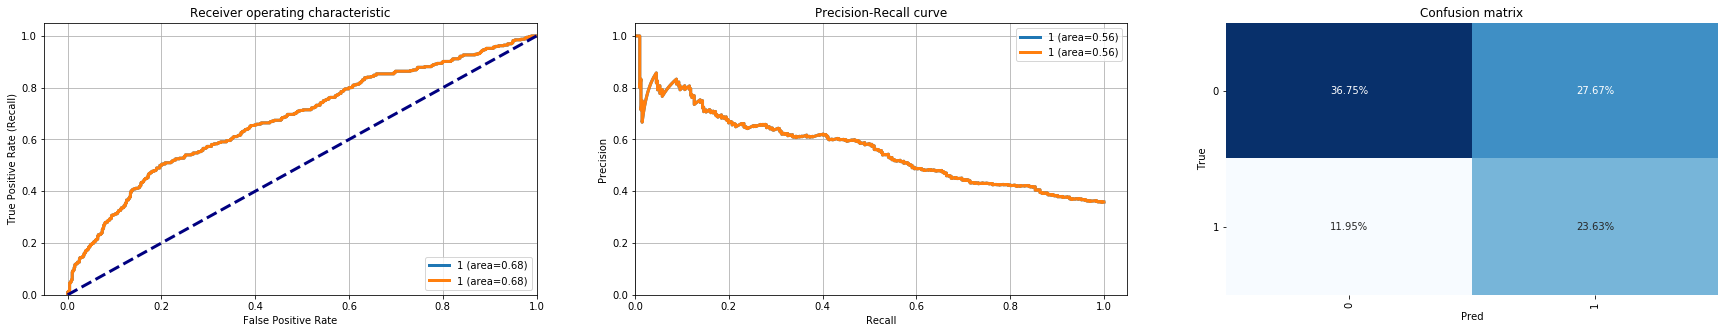

1113/1113 [==============================] - 0s 70us/step


In [43]:
## LSTM on text- Sarcasam -metrics

model2(classifier=model, features=X_test, labels=y_test)
model.evaluate(X_test,test_labels)
predicted = model.predict(X_test)


## Hate Model

In [60]:
#train-test split

X_train,X_test,y_train,y_test = train_test_split(df_final['Semi_cleaned_text'],df_final.iloc[:,2:3],test_size = 0.25,stratify=df_final.iloc[:,1:2], shuffle = True)

#converting to catrgorical
train_labels = to_categorical(np.asarray(y_train))
test_labels  = to_categorical(np.asarray(y_test))

In [61]:
## creating tokenizers
X_train_list = X_train.to_list()

tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_train_list)

vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
maxlen = 20 #word length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [62]:
#urban dictionar word2vec
word_dic = {}
for key in fasttext_ud.vocab:
    word_dic[key] = fasttext_ud.get_vector(key)

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(6539, 300)

In [63]:
#model def
model = Sequential()
model.add(Embedding(vocab_size,300,trainable = False,weights=[embedding_matrix],input_length=20))
model.add(LSTM(output_dim=16,activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
print(model.summary())


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 20, 300)           1961700   
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 16)            20288     
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 16)            64        
_________________________________________________________________
flatten_13 (Flatten)         (None, 320)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 320)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)               

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=16)`
  after removing the cwd from sys.path.


In [64]:
#model compile and fit
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
class_weight = {0: 0.50,1: 1.5}
model.fit(X_train, train_labels, batch_size=16, epochs=10,validation_split=0.2,class_weight=class_weight)

Train on 2670 samples, validate on 668 samples
Epoch 1/10
2670/2670 [==============================] - 2s 599us/step - loss: 0.8063 - accuracy: 0.4524 - val_loss: 0.5751 - val_accuracy: 0.3563
Epoch 2/10
2670/2670 [==============================] - 1s 401us/step - loss: 0.5818 - accuracy: 0.4127 - val_loss: 0.5499 - val_accuracy: 0.3563
Epoch 3/10
2670/2670 [==============================] - 1s 419us/step - loss: 0.5588 - accuracy: 0.4311 - val_loss: 0.5309 - val_accuracy: 0.3563
Epoch 4/10
2670/2670 [==============================] - 1s 412us/step - loss: 0.5348 - accuracy: 0.4625 - val_loss: 0.5179 - val_accuracy: 0.4626
Epoch 5/10
2670/2670 [==============================] - 1s 413us/step - loss: 0.5276 - accuracy: 0.4933 - val_loss: 0.5167 - val_accuracy: 0.5090
Epoch 6/10
2670/2670 [==============================] - 1s 469us/step - loss: 0.5280 - accuracy: 0.5064 - val_loss: 0.5204 - val_accuracy: 0.5419
Epoch 7/10
2670/2670 [==============================] - 1s 409us/step - loss:

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       729
           1       0.53      0.60      0.56       384

    accuracy                           0.68      1113
   macro avg       0.65      0.66      0.65      1113
weighted avg       0.69      0.68      0.68      1113



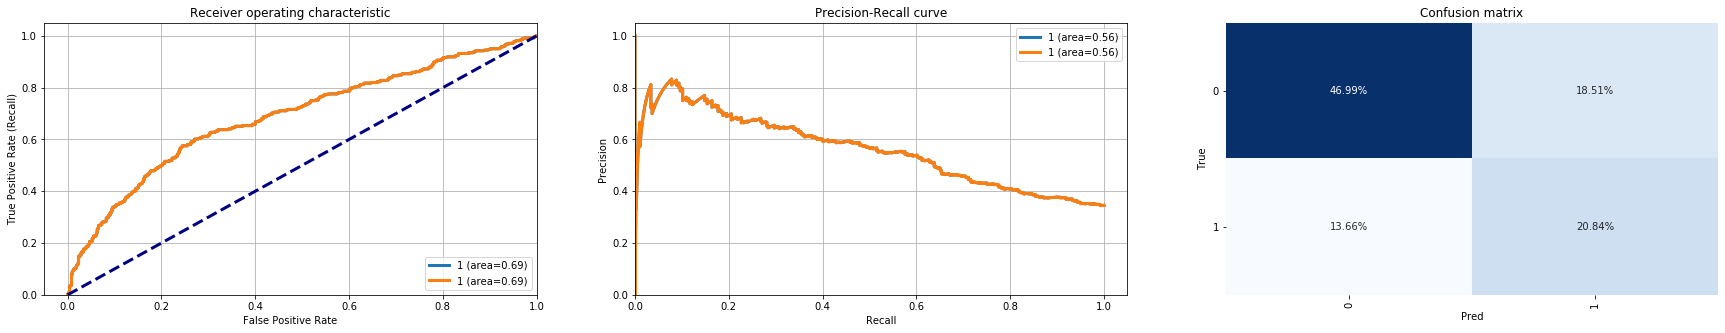

1113/1113 [==============================] - 0s 85us/step


In [65]:
## LSTM on text- Sarcasam

model2(classifier=model, features=X_test, labels=y_test)
model.evaluate(X_test,test_labels)
predicted = model.predict(X_test)


## LSTM on text- Category 

In [79]:
#train-test split
df_final['Category'].loc[df_final['Category'] ==5] = 0
X_train,X_test,y_train,y_test = train_test_split(df_final['Semi_cleaned_text'],df_final.iloc[:,3:4],test_size = 0.25,stratify=df_final.iloc[:,1:2], shuffle = True)

#converting to catrgorical
train_labels = to_categorical(np.asarray(y_train))
test_labels  = to_categorical(np.asarray(y_test))

c:\python_3.7\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\python_3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
## creating tokenizers

X_train_list = X_train.to_list()

tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_train_list)

vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [81]:
#urban dictionar word2vec
word_dic = {}
for key in fasttext_ud.vocab:
    word_dic[key] = fasttext_ud.get_vector(key)

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(6511, 300)

In [82]:
model = Sequential()
model.add(Embedding(vocab_size,300,trainable = False,weights=[embedding_matrix],input_length=20))
model.add(LSTM(output_dim=16,activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
print(model.summary())

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=16)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 20, 300)           1953300   
_________________________________________________________________
lstm_19 (LSTM)               (None, 20, 16)            20288     
_________________________________________________________________
dropout_37 (Dropout)         (None, 20, 16)            0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 16)            64        
_________________________________________________________________
flatten_19 (Flatten)         (None, 320)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 320)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)               

In [83]:
class_weight = {0: 0.50,1: 3,2: 1.5,3: 1.5,4: 3.5}
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X_train, train_labels, batch_size=16, epochs=10,validation_split=0.2)#,class_weight=class_weight)

Train on 2670 samples, validate on 668 samples
Epoch 1/10
2670/2670 [==============================] - 2s 573us/step - loss: 1.8202 - accuracy: 0.3599 - val_loss: 1.4328 - val_accuracy: 0.4910
Epoch 2/10
2670/2670 [==============================] - 1s 401us/step - loss: 1.4115 - accuracy: 0.4809 - val_loss: 1.3299 - val_accuracy: 0.5269
Epoch 3/10
2670/2670 [==============================] - 1s 408us/step - loss: 1.2749 - accuracy: 0.5431 - val_loss: 1.2236 - val_accuracy: 0.5569
Epoch 4/10
2670/2670 [==============================] - 1s 359us/step - loss: 1.1527 - accuracy: 0.5854 - val_loss: 1.0772 - val_accuracy: 0.6198
Epoch 5/10
2670/2670 [==============================] - 1s 365us/step - loss: 1.0516 - accuracy: 0.6333 - val_loss: 1.0137 - val_accuracy: 0.6617
Epoch 6/10
2670/2670 [==============================] - 1s 371us/step - loss: 1.0016 - accuracy: 0.6498 - val_loss: 0.9884 - val_accuracy: 0.6766
Epoch 7/10
2670/2670 [==============================] - 1s 387us/step - loss:

In [88]:
model.evaluate(X_test,test_labels)
predicted = model.predict(X_test)
print(classification_report(test_labels, predicted.round()))
cm=multilabel_confusion_matrix(test_labels, predicted.round())
print(multilabel_confusion_matrix(test_labels, predicted.round()))

1113/1113 [==============================] - 0s 61us/step
              precision    recall  f1-score   support

           0       0.70      0.85      0.76       570
           1       0.78      0.05      0.10       135
           2       0.77      0.54      0.64       133
           3       0.82      0.59      0.69       174
           4       0.58      0.19      0.28       101

   micro avg       0.72      0.61      0.66      1113
   macro avg       0.73      0.44      0.49      1113
weighted avg       0.72      0.61      0.61      1113
 samples avg       0.61      0.61      0.61      1113

[[[332 211]
  [ 88 482]]

 [[976   2]
  [128   7]]

 [[959  21]
  [ 61  72]]

 [[916  23]
  [ 71 103]]

 [[998  14]
  [ 82  19]]]


## Multimodal Classification
## LSTM on text and MLP on classifier

choose mlp classifier after count vectorizer because labels and objects are count dpendent

## Hate Label

In [142]:
from keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Dense,Flatten,Input,concatenate
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Input,GlobalMaxPooling1D,Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras.initializers import Constant
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM
from keras.layers import BatchNormalization,Flatten, Dense

In [143]:
# subsetting required datframe
df_final2=df_train_test[['Semi_cleaned_text','label_objects','Hate_label','Sarcasm_label','Category']]

# removing ',' from label_objects list
def simple_clean(text):
    words = text.split(',')
    return ' '.join(words)
df_final2['label_objects'] = [simple_clean(df_final2['label_objects'][i]) for i in range(len(df_final2['label_objects']))]

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
# train-test split of label_objects
train_x_label_object, valid_x_label_object, train_y_label_object, valid_y_label_object = \
    train_test_split(df_final2['label_objects'], df_final2.iloc[:,2:3], test_size=0.2, random_state=42,stratify=df_final2.iloc[:,2:3], shuffle = True)

# Word-level count vector of label objects
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_final2['label_objects'])
xtrain_count_label_object = count_vect.transform(train_x_label_object)
xvalid_count_label_object = count_vect.transform(valid_x_label_object)

In [145]:
# train-test split of text
X_train,X_test,y_train,y_test = train_test_split(df_final2['Semi_cleaned_text'],df_final2.iloc[:,2:3],test_size = 0.2,random_state=42,stratify=df_final2.iloc[:,2:3], shuffle = True)

train_labels = to_categorical(np.asarray(y_train))
test_labels  = to_categorical(np.asarray(y_test))


In [146]:
## creating tokenizers
X_train_list = df_final2['Semi_cleaned_text'].to_list()
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_train_list)

vocab_size = len(tokenizer.word_index) + 1
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [147]:
##urban dictionar word2vec embedding matrix
word_dic = {}
for key in fasttext_ud.vocab:
    word_dic[key] = fasttext_ud.get_vector(key)

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    embedding_matrix.shape


In [148]:
## LSTM on text- 

#MLP model -branch
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(512, input_dim=dim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation="relu"))
    return model

#LSTM model-branch
def lstm_model(vocab_size,embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,300,trainable = False,weights=[embedding_matrix],input_length=20))
    model.add(LSTM(output_dim=256,activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    return model

#combining branches
mlp = create_mlp(xtrain_count_label_object.shape[1], regress=False)
lstm = lstm_model(vocab_size,embedding_matrix)
combinedInput = concatenate([mlp.output, lstm.output])

#neural nr=etwork after combination
x = Dense(64, activation="relu")(combinedInput)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)


model = Model(inputs=[mlp.input, lstm.input], outputs=x)
print(model.summary())

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=256)`
  app.launch_new_instance()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_32_input (InputLayer) (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 20, 300)      2271000     embedding_32_input[0][0]         
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 20, 256)      570368      embedding_32[0][0]               
__________________________________________________________________________________________________
dense_68_input (InputLayer)     (None, 2289)         0                                            
____________________________________________________________________________________________

In [149]:
import keras
#early stopping criteria
cs = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)
#class weights to penalise/remodify model weights
class_weight = {0: 0.50,1: 2.5}


# model compile
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [131]:
#fitting model
model.fit(
    x=[xtrain_count_label_object.todense(), X_train], y=train_labels,validation_split=0.2,shuffle=True,class_weight =class_weight,
    epochs=10, batch_size=16)

Train on 2848 samples, validate on 712 samples
Epoch 1/10
2848/2848 [==============================] - 13s 4ms/step - loss: 0.8159 - accuracy: 0.3831 - val_loss: 0.8046 - val_accuracy: 0.3862
Epoch 2/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.7263 - accuracy: 0.3564 - val_loss: 0.7956 - val_accuracy: 0.3862
Epoch 3/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.6995 - accuracy: 0.3631 - val_loss: 0.6964 - val_accuracy: 0.3862
Epoch 4/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.6919 - accuracy: 0.3539 - val_loss: 0.7709 - val_accuracy: 0.3862
Epoch 5/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.6479 - accuracy: 0.3624 - val_loss: 0.7462 - val_accuracy: 0.3862
Epoch 6/10
2848/2848 [==============================] - 13s 4ms/step - loss: 0.6278 - accuracy: 0.3638 - val_loss: 0.7436 - val_accuracy: 0.3862
Epoch 7/10
2848/2848 [==============================] - 13s 4ms/step - loss: 0.5938

In [140]:
model.evaluate([xvalid_count_label_object.todense(), X_test],test_labels)
predicted = model.predict([xvalid_count_label_object.todense(), X_test])
print(classification_report(test_labels, predicted.round()))
labels = ["0","1"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = test_labels[:, label_col]
    y_pred_label = predicted.round()[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

891/891 [==============================] - 1s 741us/step
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       574
           1       0.48      0.70      0.57       317

   micro avg       0.62      0.62      0.62       891
   macro avg       0.63      0.64      0.61       891
weighted avg       0.67      0.62      0.63       891
 samples avg       0.62      0.62      0.62       891

Confusion matrix for label 0:
[[222  95]
 [244 330]]
Confusion matrix for label 1:
[[330 244]
 [ 95 222]]


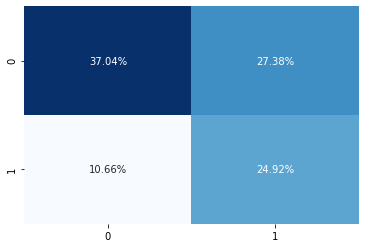

In [141]:
cm=confusion_matrix(y_true_label, y_pred_label)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%',  cmap=plt.cm.Blues, 
            cbar=False)

In [134]:
from sklearn.metrics import roc_auc_score
print('AUC: {:.3f}\n'.format(roc_auc_score(test_labels, predicted)))#,multi_class="ovr")))

AUC: 0.685



## Sarcasm Label

In [157]:
# train test split for label objects
train_x_label_object, valid_x_label_object, train_y_label_object, valid_y_label_object = \
    train_test_split(df_final2['label_objects'], df_final2.iloc[:,3:4], test_size=0.2, random_state=42,stratify=df_final2.iloc[:,3:4], shuffle = True)

In [158]:
# Word-level count vector for label objects
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_final2['label_objects'])
xtrain_count_label_object = count_vect.transform(train_x_label_object)
xvalid_count_label_object = count_vect.transform(valid_x_label_object)

In [159]:
#train test split for texts
X_train,X_test,y_train,y_test = train_test_split(df_final2['Semi_cleaned_text'],df_final2.iloc[:,3:4],test_size = 0.2,random_state=42,stratify=df_final2.iloc[:,3:4], shuffle = True)

train_labels = to_categorical(np.asarray(y_train))
test_labels  = to_categorical(np.asarray(y_test))


In [160]:
#text tokenizer
X_train_list = df_final2['Semi_cleaned_text'].to_list()
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_train_list)

vocab_size = len(tokenizer.word_index) + 1
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [161]:
#urban dict word2vec
word_dic = {}
for key in fasttext_ud.vocab:
    word_dic[key] = fasttext_ud.get_vector(key)

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    embedding_matrix.shape


In [162]:
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(512, input_dim=dim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation="relu"))
    return model

def lstm_model(vocab_size,embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,300,trainable = False,weights=[embedding_matrix],input_length=20))
    model.add(LSTM(output_dim=256,activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    return model

mlp = create_mlp(xtrain_count_label_object.shape[1], regress=False)
lstm = lstm_model(vocab_size,embedding_matrix)
combinedInput = concatenate([mlp.output, lstm.output])

x = Dense(64, activation="relu")(combinedInput)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)


model = Model(inputs=[mlp.input, lstm.input], outputs=x)
print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=256)`
  if sys.path[0] == '':


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_34_input (InputLayer) (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 20, 300)      2271000     embedding_34_input[0][0]         
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, 20, 256)      570368      embedding_34[0][0]               
__________________________________________________________________________________________________
dense_80_input (InputLayer)     (None, 2289)         0                                            
____________________________________________________________________________________________

In [164]:
#early stopping criteria
import keras
cs = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)
class_weight = {0: 0.50,1: 1.5}

In [163]:
#fitting model
model.fit(
    x=[xtrain_count_label_object.todense(), X_train], y=train_labels,validation_split=0.2,shuffle=True,class_weight =class_weight,
    epochs=10, batch_size=16)


Train on 2848 samples, validate on 712 samples
Epoch 1/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.5772 - accuracy: 0.6766 - val_loss: 0.4795 - val_accuracy: 0.6994
Epoch 2/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.4946 - accuracy: 0.6903 - val_loss: 0.5378 - val_accuracy: 0.6994
Epoch 3/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.4702 - accuracy: 0.6910 - val_loss: 0.4485 - val_accuracy: 0.6994
Epoch 4/10
2848/2848 [==============================] - 12s 4ms/step - loss: 0.4555 - accuracy: 0.6917 - val_loss: 0.4681 - val_accuracy: 0.6994
Epoch 5/10
2848/2848 [==============================] - 13s 5ms/step - loss: 0.4376 - accuracy: 0.6921 - val_loss: 0.4780 - val_accuracy: 0.6994
Epoch 6/10
2848/2848 [==============================] - 13s 4ms/step - loss: 0.4040 - accuracy: 0.6935 - val_loss: 0.4643 - val_accuracy: 0.6994
Epoch 7/10
2848/2848 [==============================] - 13s 5ms/step - loss: 0.3810

In [155]:
#evaluating model
model.evaluate([xvalid_count_label_object.todense(), X_test],test_labels)
predicted = model.predict([xvalid_count_label_object.todense(), X_test])
print(classification_report(test_labels, predicted.round()))
labels = ["0","1"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = test_labels[:, label_col]
    y_pred_label = predicted.round()[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=256)`


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_32_input (InputLayer) (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 20, 300)      2271000     embedding_32_input[0][0]         
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 20, 256)      570368      embedding_32[0][0]               
__________________________________________________________________________________________________
dense_68_input (InputLayer)     (None, 2289)         0                                            
____________________________________________________________________________________________

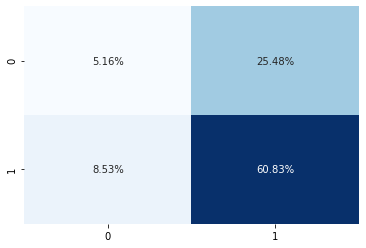

In [156]:
cm=confusion_matrix(y_true_label, y_pred_label)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%',  cmap=plt.cm.Blues, 
            cbar=False)

In [165]:
from sklearn.metrics import roc_auc_score
print('AUC: {:.3f}\n'.format(roc_auc_score(test_labels, predicted)))#,multi_class="ovr")))

AUC: 0.584



## Category Label

In [184]:
df_final2['Category'].loc[df_final2['Category'] ==5] = 0
train_x_label_object, valid_x_label_object, train_y_label_object, valid_y_label_object = \
    train_test_split(df_final2['label_objects'], df_final2.iloc[:,4:5], test_size=0.2, random_state=42,stratify=df_final2.iloc[:,4:5], shuffle = True)


c:\python_3.7\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\python_3.7\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [185]:
# Word-level count vector
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_final2['label_objects'])
xtrain_count_label_object = count_vect.transform(train_x_label_object)
xvalid_count_label_object = count_vect.transform(valid_x_label_object)


In [186]:
X_train,X_test,y_train,y_test = train_test_split(df_final2['Semi_cleaned_text'],df_final2.iloc[:,4:5],test_size = 0.2,random_state=42,stratify=df_final2.iloc[:,4:5], shuffle = True)
train_labels = to_categorical(np.asarray(y_train))
test_labels  = to_categorical(np.asarray(y_test))


In [187]:
X_train_list = df_final2['Semi_cleaned_text'].to_list()
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_train_list)

vocab_size = len(tokenizer.word_index) + 1
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [188]:
word_dic = {}
for key in fasttext_ud.vocab:
    word_dic[key] = fasttext_ud.get_vector(key)

embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_dic.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    embedding_matrix.shape

In [189]:
## LSTM on text- 

def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(512, input_dim=dim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation="relu"))
    return model


def lstm_model(vocab_size,embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,300,trainable = False,weights=[embedding_matrix],input_length=20))
    model.add(LSTM(output_dim=256,activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    return model

mlp = create_mlp(xtrain_count_label_object.shape[1], regress=False)
lstm = lstm_model(vocab_size,embedding_matrix)
combinedInput = concatenate([mlp.output, lstm.output])

x = Dense(64, activation="relu")(combinedInput)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model = Model(inputs=[mlp.input, lstm.input], outputs=x)
print(model.summary())

c:\python_3.7\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=256)`
  from ipykernel import kernelapp as app


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_36_input (InputLayer) (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 20, 300)      2271000     embedding_36_input[0][0]         
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 20, 256)      570368      embedding_36[0][0]               
__________________________________________________________________________________________________
dense_92_input (InputLayer)     (None, 2289)         0                                            
____________________________________________________________________________________________

In [190]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [191]:
import keras
cs = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)
class_weight = {0: 1,1:1,2:1,3:1,4:1,5:1}


In [192]:
model.fit(
    x=[xtrain_count_label_object.todense(), X_train], y=train_labels,validation_split=0.2,shuffle=True,class_weight =class_weight,
    epochs=10, batch_size=16)


Train on 2848 samples, validate on 712 samples
Epoch 1/10
2848/2848 [==============================] - 12s 4ms/step - loss: 1.5692 - accuracy: 0.4140 - val_loss: 1.4168 - val_accuracy: 0.5112
Epoch 2/10
2848/2848 [==============================] - 12s 4ms/step - loss: 1.4229 - accuracy: 0.5116 - val_loss: 1.4193 - val_accuracy: 0.5112
Epoch 3/10
2848/2848 [==============================] - 13s 5ms/step - loss: 1.3536 - accuracy: 0.5323 - val_loss: 1.3550 - val_accuracy: 0.5393
Epoch 4/10
2848/2848 [==============================] - 13s 5ms/step - loss: 1.2744 - accuracy: 0.5555 - val_loss: 1.3217 - val_accuracy: 0.5604
Epoch 5/10
2848/2848 [==============================] - 14s 5ms/step - loss: 1.2043 - accuracy: 0.5843 - val_loss: 1.1880 - val_accuracy: 0.5941
Epoch 6/10
2848/2848 [==============================] - 13s 5ms/step - loss: 1.1275 - accuracy: 0.6067 - val_loss: 1.1268 - val_accuracy: 0.6264
Epoch 7/10
2848/2848 [==============================] - 13s 5ms/step - loss: 1.0507

In [193]:
model.evaluate([xvalid_count_label_object.todense(), X_test],test_labels)
predicted = model.predict([xvalid_count_label_object.todense(), X_test])
print(classification_report(test_labels, predicted.round()))
# print(multilabel_confusion_matrix(test_labels, predicted.round()))
labels = ["0","1","2","3","4"]
conf_mat_dict={}
for label_col in range(len(labels)):
    y_true_label = test_labels[:, label_col]
    y_pred_label = predicted.round()[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)

891/891 [==============================] - 1s 992us/step
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       469
           1       0.00      0.00      0.00       101
           2       0.88      0.45      0.59       110
           3       0.93      0.32      0.48       134
           4       0.00      0.00      0.00        77

   micro avg       0.77      0.43      0.55       891
   macro avg       0.51      0.28      0.35       891
weighted avg       0.64      0.43      0.50       891
 samples avg       0.43      0.43      0.43       891

Confusion matrix for label 0:
[[320 102]
 [179 290]]
Confusion matrix for label 1:
[[790   0]
 [101   0]]
Confusion matrix for label 2:
[[774   7]
 [ 61  49]]
Confusion matrix for label 3:
[[754   3]
 [ 91  43]]
Confusion matrix for label 4:
[[814   0]
 [ 77   0]]


c:\python_3.7\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python_3.7\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Naive Bayes - Base Model

## Hate Model

In [206]:
#subset required fields
df_final3 = df_train_test[['Semi_cleaned_text','Sarcasm_label','Hate_label','Category']]

In [207]:
# strartify Split data into train and test 
def train_test_stratify_split(X,Y):
    from sklearn.model_selection import train_test_split
    train_x, test_x, train_y, test_y = train_test_split(X, Y,stratify=Y, test_size=0.2, random_state=42)
    return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y=train_test_stratify_split(df_final3['Semi_cleaned_text'],df_final3['Hate_label'])

In [208]:
#encoding a column
def col_encoding(to_fit,to_transform):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    to_fit = encoder.fit_transform(to_fit)
    to_transform = encoder.transform(to_transform)
    classes=encoder.inverse_transform(np.unique(to_fit))
    return to_fit,to_transform,classes
train_y,test_y,classes=col_encoding(train_y,test_y)

In [209]:
#create TF-IDF vectorizer with n-gram
def tfidf_ngram(df_col,X,Y):
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',ngram_range=(2,3))#, max_features=5000)
    tfidf_vect.fit(df_col)
    xtrain_tfidf =  tfidf_vect.transform(X)
    xtest_tfidf =  tfidf_vect.transform(Y)
    return xtrain_tfidf,xtest_tfidf,tfidf_vect

In [210]:
xtrain_tfidf,xtest_tfidf,tfidf_vect=tfidf_ngram(df_final3['Semi_cleaned_text'],train_x,test_x)

In [211]:
#metrics function for models
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report  
import seaborn as sns
import matplotlib.pyplot as plt
def model(classifier, train_features, test_features):
    #if classifier in (MultinomialNB,RandomForestClassifier,kn_clf):
    predict_y = classifier.predict(test_features)        
    #else:
    #    predict_y = classifier.predict_classes(test_features)
    predicted_prob = classifier.predict_proba(test_features)
    y_test_array = pd.get_dummies(test_y, drop_first=False).values
    print('classification_report\n',classification_report(test_y, predict_y))
    print('Confusion Matrix')
    cm=confusion_matrix(test_y, predict_y)    
#     print('AUC: {:.3f}\n'.format(roc_auc_score(test_y, predicted_prob,multi_class="ovr")))
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(30,5))
    
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                               predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    
    
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[2], cmap=plt.cm.Blues, 
            cbar=False)
    ax[2].set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    return

In [214]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False], 
}
clf = GridSearchCV(MultinomialNB(), grid_params)
clf.fit(xtrain_tfidf, train_y)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.6362359550561798
Best Params:  {'alpha': 1.5, 'fit_prior': True}


In [215]:
# Naive Bayes: N-Gram level TF-IDF and word2vec
from sklearn.naive_bayes import MultinomialNB
MultinomialNB=MultinomialNB(alpha= 1.5, fit_prior= True)
MultinomialNB.fit(xtrain_tfidf,train_y)

MultinomialNB(alpha=1.5, class_prior=None, fit_prior=True)

classification_report
               precision    recall  f1-score   support

           0       0.64      0.97      0.77       574
           1       0.24      0.02      0.04       317

    accuracy                           0.63       891
   macro avg       0.44      0.49      0.40       891
weighted avg       0.50      0.63      0.51       891

Confusion Matrix


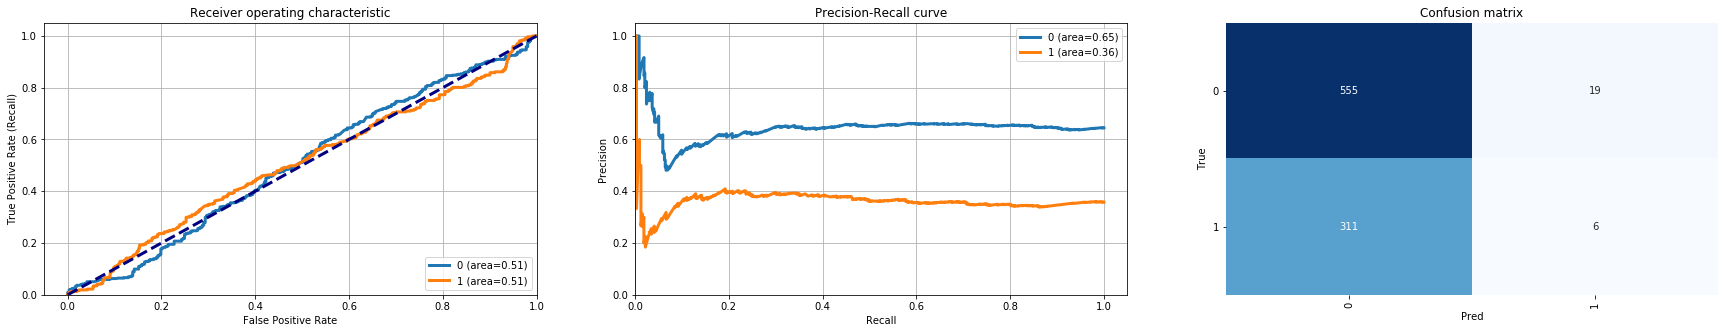

In [216]:
model(MultinomialNB, xtrain_tfidf, xtest_tfidf)

In [217]:
##  Naive Bayes gave 0.51 F1-score which is very less. 

## Sarcasm Label

Best Score:  0.6941011235955056
Best Params:  {'alpha': 0.7, 'fit_prior': True}
classification_report
               precision    recall  f1-score   support

           0       0.83      0.02      0.04       273
           1       0.70      1.00      0.82       618

    accuracy                           0.70       891
   macro avg       0.77      0.51      0.43       891
weighted avg       0.74      0.70      0.58       891

Confusion Matrix


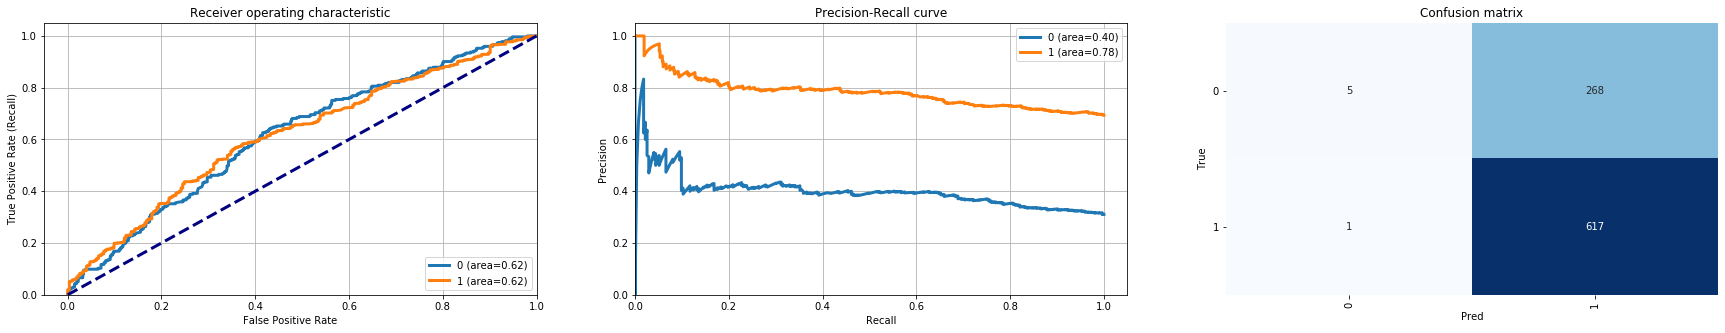

In [219]:
train_x, test_x, train_y, test_y=train_test_stratify_split(df_final3['Semi_cleaned_text'],df_final3['Sarcasm_label'])
train_y,test_y,classes=col_encoding(train_y,test_y)
xtrain_tfidf,xtest_tfidf,tfidf_vect=tfidf_ngram(df_final3['Semi_cleaned_text'],train_x,test_x)
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False], 
}
clf = GridSearchCV(MultinomialNB(), grid_params)
clf.fit(xtrain_tfidf, train_y)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
# Naive Bayes: N-Gram level TF-IDF and word2vec
from sklearn.naive_bayes import MultinomialNB
MultinomialNB=MultinomialNB(alpha= 1.5, fit_prior= True)
MultinomialNB.fit(xtrain_tfidf,train_y)
model(MultinomialNB, xtrain_tfidf, xtest_tfidf)